In [1]:
import torch
from torchinfo import summary
from tqdm import tqdm
import TorchData
from sklearn.metrics import roc_auc_score

In [2]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from 'F:\\projects\\ResearchProject\\TorchData\\__init__.py'>

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [4]:
NUM_DATA = 1024
BATCH_SIZE = 256
EPOCH = 100

In [5]:
train_dataset = TorchData.TORCHDataset2Channel(num_data=NUM_DATA)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [6]:
test_dataset = TorchData.TORCHDataset2Channel(num_data=1024)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

In [7]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 2, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
model = ConvolutionAutoencoder()
model = torch.nn.DataParallel(model)
model = model.to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
summary(model, input_size=(1, 2, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 2, 120, 92]           --
├─Sequential: 1-1                        [1, 8, 114, 86]           --
│    └─Conv2d: 2-1                       [1, 64, 118, 90]          1,216
│    └─BatchNorm2d: 2-2                  [1, 64, 118, 90]          128
│    └─ReLU: 2-3                         [1, 64, 118, 90]          --
│    └─Conv2d: 2-4                       [1, 16, 116, 88]          9,232
│    └─BatchNorm2d: 2-5                  [1, 16, 116, 88]          32
│    └─ReLU: 2-6                         [1, 16, 116, 88]          --
│    └─Conv2d: 2-7                       [1, 8, 114, 86]           1,160
│    └─BatchNorm2d: 2-8                  [1, 8, 114, 86]           16
│    └─ReLU: 2-9                         [1, 8, 114, 86]           --
├─Sequential: 1-2                        [1, 2, 120, 92]           --
│    └─BatchNorm2d: 2-10                 [1, 8, 114, 86]           16
│    

In [10]:
for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()
        outputs = model(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser.step()

  0%|          | 0/100 [00:00<?, ?it/s]F:\projects\ResearchProject\TorchData\__init__.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


In [31]:
torch.save(model.state_dict(), f"Conv2Channel_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth")

In [9]:
### Using pretrained weights
model.load_state_dict(torch.load("ModelWeights/Conv2Channel/Conv2Channel_1024_256_100.pth", weights_only=True))

<All keys matched successfully>

In [21]:
model.eval()
with torch.no_grad():
    all_pred = model.to("cpu")(test_dataset.x.to("cpu"))

all_pred_time = all_pred * test_dataset.sn_time
all_pred_time[all_pred_time < 0.5] = 0

In [27]:
all_pred[:, 0].shape

torch.Size([1024, 120, 92])

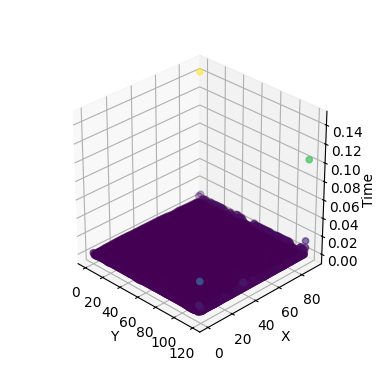

In [28]:
TorchData.visual.plot3d(all_pred[:, 0][0])

In [22]:
all_pred_time_a = all_pred_time[:, 0].unsqueeze(1)
all_pred_time_b = all_pred_time[:, 1].unsqueeze(1)
all_pred_time_c = (all_pred_time_a + all_pred_time_b) / 2

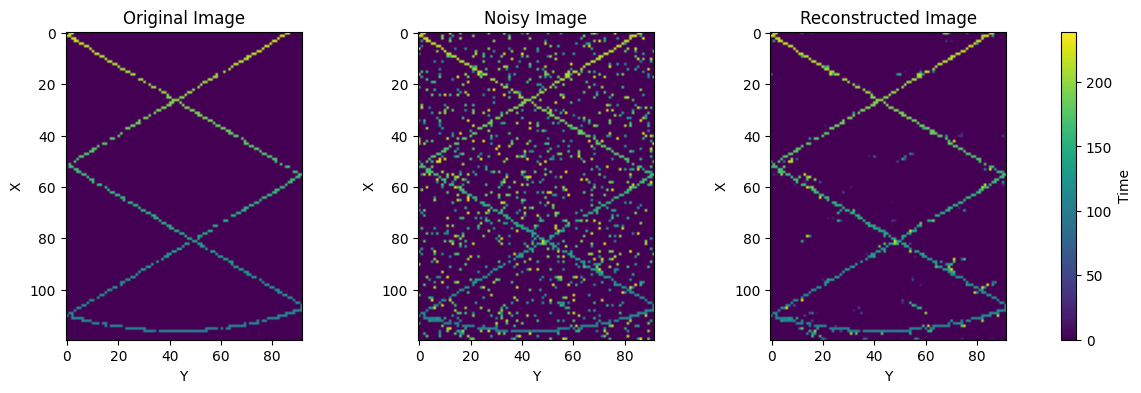

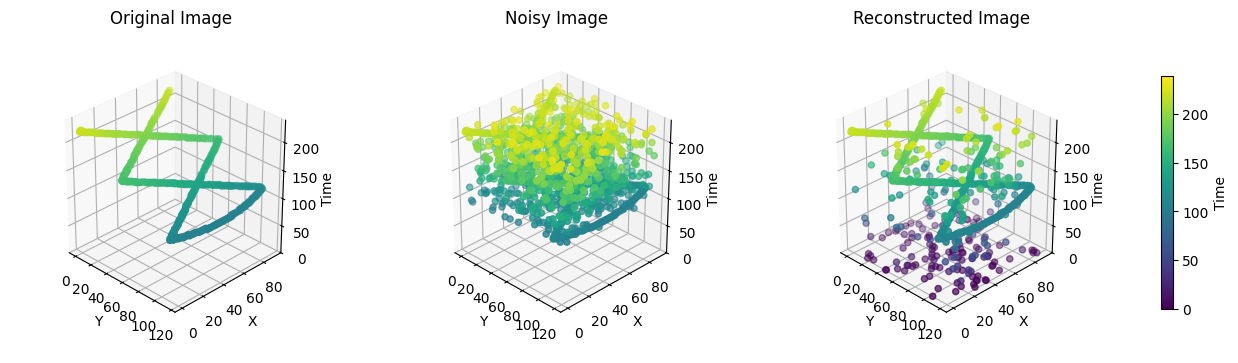

In [23]:
TorchData.visual.fast_compare_plot(test_dataset, all_pred_time_b, 0)

In [18]:
mse = TorchData.metric.calculate_mse_torch(test_dataset.signal_time, all_pred_time_b)
psnr = TorchData.metric.calculate_psnr_torch(test_dataset.signal_time, all_pred_time_b)
ssim = TorchData.metric.calculate_ssim_torch(test_dataset.signal_time, all_pred_time_b)
roc_auc = roc_auc_score(test_dataset.signal.flatten().numpy(), all_pred_time_b.flatten().numpy())
print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

MSE: 314.9856, PSNR: 21.8655, SSIM: 0.7928, ROC AUC: 0.9949
